# Install Libraries

In [ ]:
%pip install datasets
%pip install -q git+https://github.com/huggingface/transformers.git
%pip install segment-geospatial

# Import Dependencies

In [130]:
from datasets import Dataset, load_dataset
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
import torch
from PIL import Image
import io
import os
import leafmap
from samgeo import SamGeo, tms_to_geotiff

# Load in and Prepare Dataset

In [ ]:
sidewalk_test = load_dataset("back2classroom/sidewalks", split='val', streaming=True)

In [4]:
test_images = []
test_labels = []

# Loop through the streamed dataset and collect images and masks
for sample in sidewalk_test:
    test_images.append(sample['tif'])
    test_labels.append(sample['label_tif'])

# Decode a JPEG byte string to a NumPy array
def decode_jpeg_to_array(jpeg_bytes):
    with io.BytesIO(jpeg_bytes) as byte_stream:
        image = Image.open(byte_stream)
        return np.array(image)

valid_indices = []
false_counter = 0

for i, mask_bytes in enumerate(test_labels):
    mask_np = decode_jpeg_to_array(mask_bytes)
    # Check if any pixel in the mask is not zero
    if np.any(mask_np != 0):
        valid_indices.append(i)
    else:
        false_counter += 1

print("Empty masks: ", false_counter)


filtered_images = [test_images[i] for i in valid_indices]
filtered_masks = [test_labels[i] for i in valid_indices]

Empty masks:  9917


In [5]:


# Convert byte arrays to numpy arrays
def convert_to_numpy(byte_data):
    with io.BytesIO(byte_data) as byte_stream:
        image = Image.open(byte_stream)
        image_np = np.array(image)
        return image_np

def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox


dataset_dict = {
    "image": filtered_images,  # Directly use the byte data
    "label": filtered_masks,   # Directly use the byte data
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

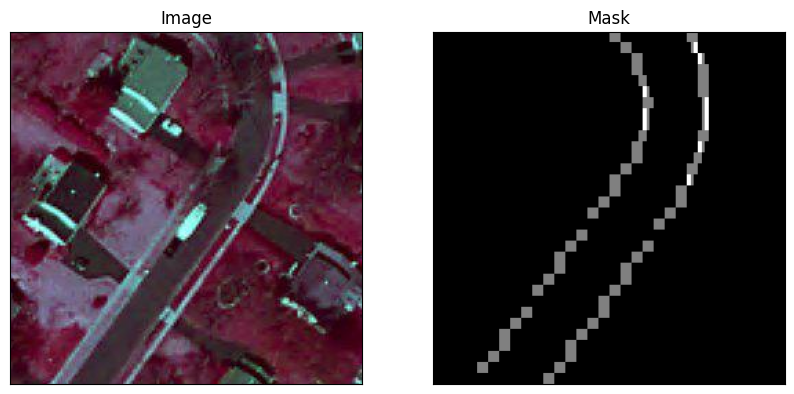

In [6]:

img_num = random.randint(0, convert_to_numpy(filtered_images[0]).shape[0]-1)

image_np = dataset[img_num]["image"]
mask_np = dataset[img_num]["label"]

image_np = convert_to_numpy(image_np)
mask_np = convert_to_numpy(mask_np)

example_image = Image.fromarray(image_np)
example_mask = Image.fromarray(mask_np)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

# Load Trained Model
Eventually use this for inferring masks to use on map

In [7]:
from transformers import SamModel, SamConfig, SamProcessor

# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [9]:
train_model_path = "/content/drive/MyDrive/Colab Notebooks/model_checkpoint_trained_on_train.pth"

# Create an instance of the model architecture with the loaded configuration
train_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
train_model.load_state_dict(torch.load(train_model_path))

<All keys matched successfully>

In [11]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
train_model.to(device)
print(device)

cuda


# Initialize SamGeo Class

Theoretically can use this to create interactive mask, may not need training model above. If this works, we can follow this [tutorial](https://samgeo.gishub.org/examples/input_prompts/#initialize-sam-class) Himanshu posted in the group. Rather large issue is that it needs geo coordinates to work, and Pantelis did not give us those?

In [134]:
# SamGeo will look for a file specifically named sam_vit_l_0b3195.pth in this directory because this API needs work
train_model_dir = "/content/drive/MyDrive/Colab Notebooks/"

trainGeo = SamGeo(model_type="vit_h", automatic=False, sam_kwargs=None, checkpoint_dir=train_model_dir)

In [149]:
idx = 3
test_image = convert_to_numpy(dataset[idx]["image"])
trainGeo.set_image(test_image)